In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from adapters import *
from dataset import NumpyCsvDataSet
from runner import ExptRunner
from networks.autoencoder import AutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.etpr.autoencoder import autoencoder as etprautoenc
from networks.dense import Dense
from networks.dense import DenseForPolicy
from networks.lossfunctions import *
from helpers import ReportResults

In [3]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print (device)

cpu


In [5]:
start = time.time()
data_folder = 'data/demoplanner/version1'
v1_train_data = NumpyCsvDataSet(data_folder + '/train.csv', device=device)
v1_test_data = NumpyCsvDataSet(data_folder + '/test.csv', device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 31.081373929977417 sec


In [6]:
test_data_float = v1_test_data.data
train_data_float = v1_train_data.data

In [7]:
print (train_data_float.shape)
print (test_data_float.shape)

print (train_data_float.device)
print (test_data_float.device)

torch.Size([13280, 2058])
torch.Size([1341, 2058])
cpu
cpu


In [8]:
map_netname_net = {
    'ComposedAutoEncoderWithMaxPool': lambda: ComposedAutoEncoder(useMaxPool=True),
    'DenseAutoEncoder3': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]),
    'ComposedAutoEncoderNoMaxPool': lambda: ComposedAutoEncoder(useMaxPool=False),
    'VAE': VAE,
    'ConvVAE': ConvVae,
    'EtprEncoder': etprautoenc,
    '03-31-18-02-15-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 2]),
    '03-31-18-02-32-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 8, 2]),
    '03-31-18-02-52-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 16, 2]),
    '03-31-18-01-03-Dynamics-V1-Dense-MSE': lambda: Dense([4, 2]),
    '03-31-18-01-22-Dynamics-V1-Dense-MSE': lambda: Dense([4, 8, 2]),
    '03-31-18-01-50-Dynamics-V1-Dense-MSE': lambda: Dense([4, 16, 2]),
}     

In [11]:
rr = ReportResults(map_netname_net, device, 
                   dynamics_input_adapter, dynamics_gradient_ground_truth_adapter,
                   loss_adapter_func = l1_loss_adapter)

In [12]:
rr.generate_csv_comparison_report(test_data_float, train_data_float,
                   rootdir='runs/03-31')

Time,Goal,DataSet,Network,Loss(Training),TestLoss,TrainLoss
03:31:18:01:03,Dynamics,V1,Dense,MSE,0.0821070447564125,0.08388315141201019
03:31:18:01:22,Dynamics,V1,Dense,MSE,0.003344212891533971,0.0034352901857346296
03:31:18:01:50,Dynamics,V1,Dense,MSE,0.003786794375628233,0.003730030497536063
03:31:18:02:15,Dynamics,V1,Dense,SmoothL1,0.07136806100606918,0.07271932810544968
03:31:18:02:32,Dynamics,V1,Dense,SmoothL1,0.005948166828602552,0.006144481245428324
03:31:18:02:52,Dynamics,V1,Dense,SmoothL1,0.0032131331972777843,0.0033073569647967815


In [13]:
sample = torch.cat((test_data_float[1055:1060], test_data_float[1230:1235]), axis=0)
ground_truth = dynamics_gradient_ground_truth_adapter(sample).to(device)
for folder, net in rr.build_net(rootdir='runs/03-31/'):
    print ('Folder: ' + folder)
    op_batch, loss = rr.run_mini_batch(net, sample)
    print (ground_truth)
    print (op_batch)
    print (loss)
    print ('-----------------------------------------')

Folder: 03-31-18-01-03-Dynamics-V1-Dense-MSE
tensor([[0.0000, 0.5000],
        [0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.5000]])
tensor([[0.1214, 0.5738],
        [0.1264, 0.1509],
        [0.0993, 0.4931],
        [0.1002, 0.4953],
        [0.1011, 0.4974],
        [0.9014, 0.1185],
        [0.9010, 0.1189],
        [0.9006, 0.1193],
        [0.9003, 0.1197],
        [0.9171, 0.5654]], grad_fn=<SigmoidBackward>)
tensor(0.0904, grad_fn=<MeanBackward0>)
-----------------------------------------
Folder: 03-31-18-01-22-Dynamics-V1-Dense-MSE
tensor([[0.0000, 0.5000],
        [0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.5000]])
tensor([[0.0047, 0

In [19]:
rr = ReportResults(map_netname_net, device, 
                   policy_input_adapter, policy_groud_truth_adapter,
                   loss_adapter_func = l1_loss_adapter)

In [20]:
rr.generate_csv_comparison_report(test_data_float, train_data_float,
                   rootdir='runs/04-08')

Time,Goal,DataSet,Network,Loss(Training),TestLoss,TrainLoss
04:08:07:35:53,Policy,V2,Dense,MSE,0.0009246765985153615,0.0009788279421627522
04:08:07:29:36,Policy,V2,Dense,MSE,0.015583701431751251,0.016864705830812454


In [21]:
sample = torch.cat((test_data_float[1055:1060], test_data_float[1230:1235]), axis=0)
ground_truth = policy_groud_truth_adapter(sample).to(device)
for folder, net in rr.build_net(rootdir='runs/04-08/'):
    print ('Folder: ' + folder)
    op_batch, loss = rr.run_mini_batch(net, sample)
    print (ground_truth)
    print (op_batch)
    print (loss)

Folder: 04-08-07-35-53-Policy-V2-Dense-MSE
tensor([[-1.,  0.],
        [-1., -1.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1.,  0.]])
tensor([[-1.0000e+00, -5.9831e-04],
        [-9.9837e-01, -9.9866e-01],
        [-1.0000e+00, -2.0846e-03],
        [-1.0000e+00, -2.0014e-03],
        [-1.0000e+00, -1.9175e-03],
        [ 9.9764e-01, -9.9867e-01],
        [ 9.9765e-01, -9.9868e-01],
        [ 9.9766e-01, -9.9868e-01],
        [ 9.9767e-01, -9.9868e-01],
        [ 1.0000e+00,  7.1299e-04]], grad_fn=<TanhBackward>)
tensor(0.0012, grad_fn=<MeanBackward0>)
Folder: 04-08-07-29-36-Policy-V2-Dense-MSE
tensor([[-1.,  0.],
        [-1., -1.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1.,  0.]])
tensor([[-0.9994, -0.0311],
        [-0.9682, -0.9674],
        [-0.9995,  0.0176],
   

datapoint 0 test error tensor(9.2288e-06)


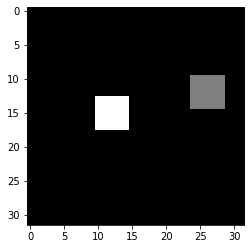

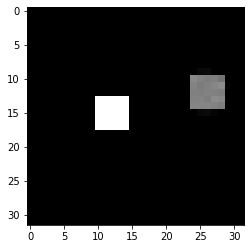

datapoint 1 test error tensor(9.4870e-06)


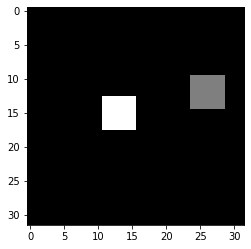

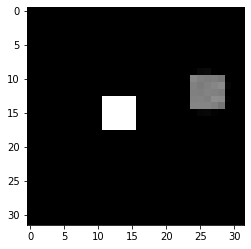

datapoint 2 test error tensor(1.5805e-05)


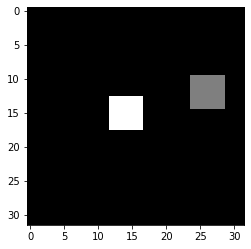

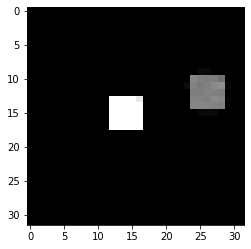

datapoint 3 test error tensor(1.1305e-05)


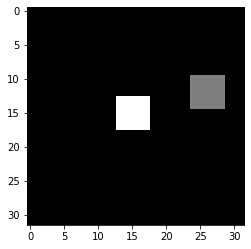

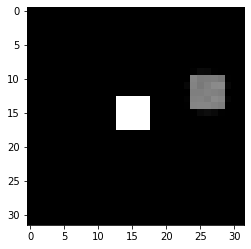

datapoint 4 test error tensor(1.3016e-05)


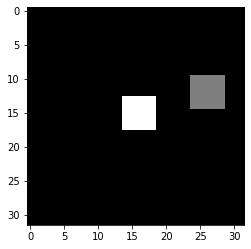

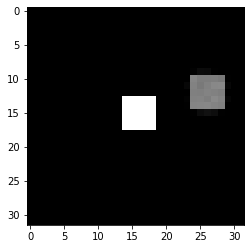

In [16]:
rr.show_test_samples(test_data_float,
                  rootdir='runs/03-28/03-28-14-10-20-DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-')

In [ ]:
np.set_printoptions(**opt)